This notebook is part of the supporting information to the manuscript entitled "Conformal Prediction and 
Exchangeability in Toxicological In Vitro Datasets (title tbd)". The script was developed by Andrea Morger in the 
In Silico Toxicology and Structural Biology Group of Prof. Dr. Andrea Volkamer at the Charité Universitätsmedizin 
Berlin, in collaboration with Fredrik Svensson, Ulf Norinder and Ola Spjuth. It was last updated in September 2020.

## Content


In this notebook, it is shown how the experiments for the CPTox21 manuscript (train model and make predictions with Tox21 data, update the training and/or calibration set) are run for multiple endpoints. Furthermore the evaluation over all enpoints in the form of boxplots is provided.

### Table of contents
1. [Preparation](#preparation) <br>
    1.1. [Import libraries and modules](#import-libraries-and-modules)<br>
    1.2. [Define paths and parameters](#define-paths-parameters)<br>
2. [Conformal prediction experiments](#cp-experiments)<br>
    2.1. [Build conformal predictors](#build-cp)<br>
    2.2. [Perform experiments for all endpoints](#perform-exp)<br>
3. [Evaluate conformal predictions](#evaluate-cp)<br>
    3.1. [Calibration plots](#cal-plots)<br>
    3.2. [rmsd's](#rmsd)<br>
    3.3. [Boxplots](#boxplots)<br>
    3.4. [Line plots](#line-plots)<br>

## 1. Preparation <a id='preparation'></a>

### 1.1. Import libraries and modules <a id='import-libraries-and-modules'></a>

In [1]:
import os
import numpy as np
import math
from pathlib import Path

In [2]:
import pandas as pd
from sklearn.svm import SVC
from nonconformist.nc import NcFactory, MarginErrFunc
import matplotlib.pyplot as plt

In [3]:
from cptox21 import (
    define_path, load_signatures_files, InductiveConformalPredictor,
    CPTox21AggregatedConformalPredictor, AggregatedConformalPredictor, 
    StratifiedRatioSampler, CrossValidationSampler, KnownIndicesSampler,
    CPTox21CrossValidator, CPTox21TrainUpdateCrossValidator,
    calculate_rmsd_from_df, calculate_rmsd_pos_from_df
)
from helper_functions import (load_data, cross_validate_compare_calibration_sets, 
                              cross_validate_with_updated_training_set, boxplot_rmsd,
                             draw_calibration_plot_all_endpoints)

In [4]:
import warnings
warnings.simplefilter("ignore")

### 1.2. Define paths and parameters <a id='define-paths-parameters'></a>

In [5]:
# Paths
HERE = Path(_dh[-1])
DATA = HERE / "../data"
data_signatures_path = DATA / "data_signatures/"
data_statistics_path = DATA / "data_statistics/"  # Use data from this directory
# data_statistics_path = DATA / "../../../KT-ER/cptox21_pipeline/data/data_curta_200909/"  # Use data created on the cluster

In [6]:
print(data_statistics_path)

/home/andrea/Documents/cptox21/cptox21_manuscript_si/code/../data/data_statistics


In [7]:
# Define if model fitting and predictions are required (set to True) or if data 
# are already available (set to False).
run_experiment = True  # False
# If we do a test run (test_run is True, we can train with a much smaller training 
# set (n=500), which will result in faster calculations). Could be deleted for final 
# notebook.
test_run = True  # False
set_random_state = None  # Set the random seed for deterministic results

In [8]:
# Parameters
# fixme: in the end, exchange with final numbers and delete rest
n_folds_acp = 3  # 10
n_cv = 2 # 5

In [9]:
# fixme: in the end, this should be adjusted to a list with ALL 12 endpoints
endpoints = ['SR_ATAD5', 'NR_ER']
# endpoints = [
#     'SR_ATAD5', 'NR_ER', 'NR_AR', 'SR_HSE', 'SR_MMP', 'SR_p53', 'NR_Aromatase',
#     'SR_ARE', 'NR_AR_LBD', 'NR_AhR', 'NR_ER_LBD', 'NR_PPAR_gamma'
# ]

## 2. Conformal prediction experiments <a id='cp-experiments'></a>

### 2.1. Build conformal predictors <a id='build-cp'></a>

In [10]:
# Build ICP (inductive conformal predictor)
clf = SVC(
    kernel='rbf', C=50, gamma=0.002, probability=True, random_state=set_random_state
)  # ML classifier
error_function = MarginErrFunc()  # Error function
normaliser_model = None  # Normaliser model
nc = NcFactory.create_nc(clf, err_func=error_function)  # Nonconformity scoreer
icp = InductiveConformalPredictor(
    nc_function=nc, condition=(lambda instance: instance[1])
)  # Mondrian as (default) condition)

In [11]:
# Build ACP (aggregated conformal predictor, to perform the experiments with the
# different calibration sets.)
acp = CPTox21AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp, random_state=set_random_state),
        aggregation_func=np.median
    )

In [12]:
# Build ACP (accepts only one calibration set, used for the experiment with the
# updated training set)
train_update_acp = AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp, random_state=set_random_state),
        aggregation_func=np.median
    )

### 2.2. Perform experiments for all endpoints <a id='perform-exp'></a>

In [13]:
evaluation_dfs = {"cv": [],
                  "pred_score": [],
                  "cal_update": [], "cal_update2": [],
                  "cv_train_update": [], "pred_score_train_update": []}

for endpoint in endpoints:
    print(endpoint)
    if run_experiment: # If we want to make calculations for all set-ups
        
        # Load data (signatures and activity labels per endpoint and 
        # Tox21 dataset (Toxtrain, Tox21test, Tox21score))
        X_train, y_train, X_test, y_test, X_score, y_score = load_data(
            endpoint, signatures_path=data_signatures_path, short_train=True
        )
        
        # Cross-validate with different calibration sets
        cptox21_cross_validator = cross_validate_compare_calibration_sets(
            endpoint, acp, X_train, y_train, X_test, y_test, X_score, y_score, n_cv=n_cv, 
            random_state=set_random_state
        )
        
        # Store dataframes with evaluation measures per set-up
        
        for strategy in ["cv", "pred_score", "cal_update", "cal_update2"]:
            evaluation_dfs[strategy].append(
                getattr(cptox21_cross_validator, f"averaged_evaluation_df_{strategy}")
            )
                    
        for strategy in ["cv", "pred_score", "pred_test", "cal_update", "cal_update2"]:
            (getattr(
                cptox21_cross_validator, f"averaged_evaluation_df_{strategy}"
            )).to_csv(os.path.join(data_statistics_path, f"{endpoint}_averaged_eval_df_{strategy}.csv")
            )
        
        # Get train and test indices from cptox21_cross_validator,
        # to use same indices for train_update
        train_index, test_index = cptox21_cross_validator.train_indices, cptox21_cross_validator.test_indices
        known_indices_sampler = KnownIndicesSampler(
            known_train=train_index, known_test=test_index
        )

        # Cross-validate with updated training set
        train_update_cross_validator = cross_validate_with_updated_training_set(
            endpoint, train_update_acp, X_train, y_train, X_test, y_test, 
            X_score, y_score, known_indices_sampler
        )
        
        # Store dataframes with evaluation measures per set-up
        for strategy in ["cv", "pred_score"]:
            evaluation_dfs[f"{strategy}_train_update"].append(
                getattr(
                    train_update_cross_validator, f"averaged_evaluation_df_{strategy}"
                )
            )

        for strategy in ["cv", "pred_score"]:
            (
                getattr(
                    train_update_cross_validator, f"averaged_evaluation_df_{strategy}"
            )
            ).to_csv(
                os.path.join(
                    data_statistics_path,
                    f"{endpoint}_averaged_eval_df_{strategy}_train_update.csv"
                )
            )
            
        
    else: # If results are already available and dataframes can be loaded directly
        
        for strategy in ["cv", "pred_score", "cal_update", "cal_update2"]:  
            evaluation_dfs[strategy].append(
                pd.read_csv(
                    os.path.join(
                        data_statistics_path,
                        f"{endpoint}_averaged_eval_df_{strategy}.csv"
                    )
                )
            )
        
        for strategy in ["cv", "pred_score"]:
            evaluation_dfs[f"{strategy}_train_update"].append(
                pd.read_csv(
                    os.path.join(
                        data_statistics_path, 
                        f"{endpoint}_averaged_eval_df_{strategy}_train_update.csv"
                    )
                )
            )
        

SR_ATAD5
NR_ER


## 3. Evaluate conformal predictions <a id='evaluate-cp'></a>

### 3.1. Calibration plots <a id='cal-plots'></a>
Using the function `draw_calibration_plot_all_endpoints`, one could see the calibration plots for all 12 endpoints. Change `strategy` to `cv`, `pred_score`, `pred_test`, `cal_update`, `train_update` etc. depending, on which conformal prediction set-up you would like to visualise.

(<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/cptox21_SI/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.legend.Legend at 0x7f8da88e7670>)

<Figure size 432x288 with 0 Axes>

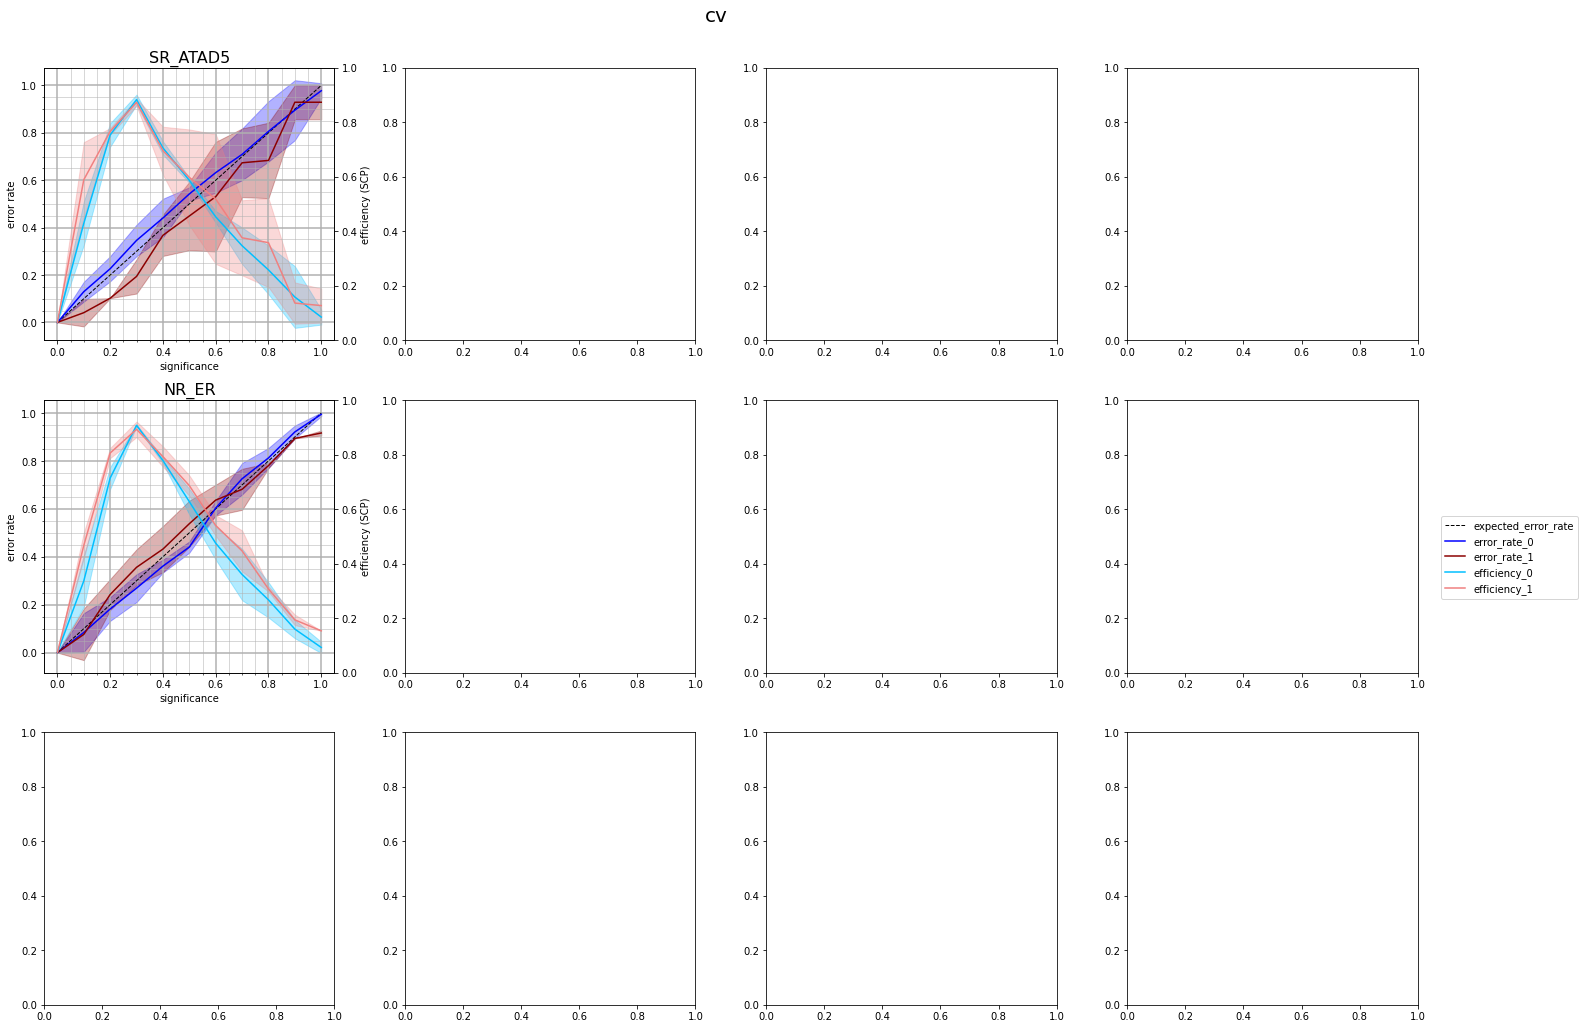

In [14]:
draw_calibration_plot_all_endpoints(endpoints=endpoints, strategy='cv', path=data_statistics_path)

### 3.2.  Root-mean-square deviations from the diagonal (rmsd) <a id='rmsd'></a>

#### Calculate rmsd's for all endpoints over all strategies

To have a value to compare the calibration plots (validity) over all experiments, we calculate the rmsd of the observed error rate to the expected error rate (for 10 significance levels). If we accept overconservative validity, we can also calculate rmsd<sub>pos</sub> (todo: change term/name?), only considering the deviation where the observed error rate is higher than the expected error rate.

In [15]:
rmsds = {}
for k, v in evaluation_dfs.items():
    rmsds[k] = []
    for df in v:
        
        rmsd = calculate_rmsd_from_df(df)
        rmsds[k].append(rmsd)

pd.DataFrame(rmsds, index=endpoints)

,cv,pred_score,cal_update,cal_update2,cv_train_update,pred_score_train_update
SR_ATAD5,0.017,0.260,0.016,0.022,0.039,0.089
NR_ER,0.017,0.124,0.029,0.021,0.015,0.066


#### Calculate rmsd<sub>pos</sub> 's for all endpoints over all strategies

In [16]:
rmsds_pos = {}
for k, v in evaluation_dfs.items():
    rmsds_pos[k] = []
    for df in v:
        rmsd_pos = calculate_rmsd_pos_from_df(df)
        rmsds_pos[k].append(rmsd_pos)
pd.DataFrame(rmsds_pos, index=endpoints)

,cv,pred_score,cal_update,cal_update2,cv_train_update,pred_score_train_update
SR_ATAD5,0.013,0.260,0.015,0.022,0.0,0.089
NR_ER,0.007,0.124,0.028,0.021,0.0,0.064


### 3.3. Boxplots <a id='boxplots'></a>

Given the rmsd's per endpoint, we can draw a boxplot over the rmsd values for all endpoints. This gives us a nice overview on how the rmsd's change among the different CP set-ups.

In [17]:
strategies = ["cv", 
              "pred_score",
              "pred_score_train_update",
              "cal_update", 
              "cal_update2"]

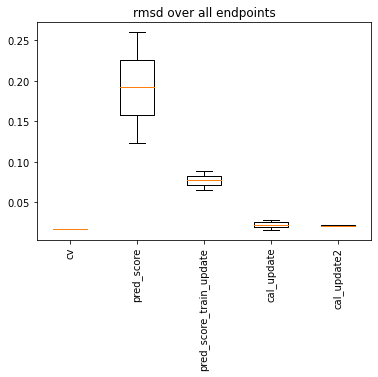

In [18]:
boxplot_rmsd(rmsds, "rmsd", strategies)

The above boxplots nicely illustrate how the calibration changes depending on the conformal prediction setup. Within the crossvalidation on Tox21train, the models are well calibrated while the calibration is worse to predict the Tox21score data.The first strategy, where the training set is updated with more recent (Tox21test) data (pred_score_train_update), improves the calibration to some extent. A better improvement can be seen when only the calibration set is exchanged with Tox21test (cal_update). The goodness of the calibration is mainly dependant on the data drifts between the calibration and prediction set. This is nicely illustrated by the well calibrated models where the calibration set is exchanged by a randomly stratified selected part of Tox21score and the other part of Tox21score is predicted (cal_update2), presuming that the calibration and prediction set are drawn from the same distribution.

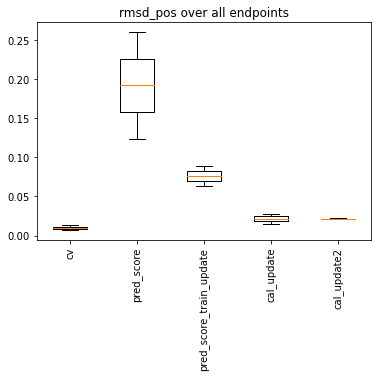

In [19]:
boxplot_rmsd(rmsds_pos, "rmsd_pos", strategies)

### 3.4. Line plots <a id='line-plots'></a>

To see how the rmsds change for the individual endpoints and detect possible "outlier endpoints", we can look at the following line plots.

Note, that these plots were initially used for internal investigation, e.g. which endpoints should be selected as example in the manuscript. If unnecessary, the plots can be deleted from this SI notebook.

In [20]:
def line_plot_rmsd(rmsds, strategies, colours=None, markers=None, figsize=(5, 10)):
    plt.clf()
    fig = plt.figure(figsize=figsize)
    if colours is None:
        colours = ['navy', 'royalblue', 'blueviolet', 'plum', 'mediumvioletred', 'red', 'coral', 'gold', 'yellowgreen', 'green', 'paleturquoise', 'slategrey']
    if markers is None:
        markers = ['3', '<', '>', 'x', 's', '+', 'd', 'h', '*', '1', 'o', 'D']
    for i, ep in enumerate(endpoints):
    
        plt.plot(strategies, [rmsds[s][i] for s in strategies], color=colours[i], linewidth=0.5)#, marker='-o')
        plt.scatter(strategies, [rmsds[s][i] for s in strategies], label=ep, color=colours[i], marker=markers[i], s=50)
        plt.xticks(rotation='vertical')
        plt.legend(endpoints, loc='upper right', bbox_to_anchor=(1.5, 1))
    

<Figure size 432x288 with 0 Axes>

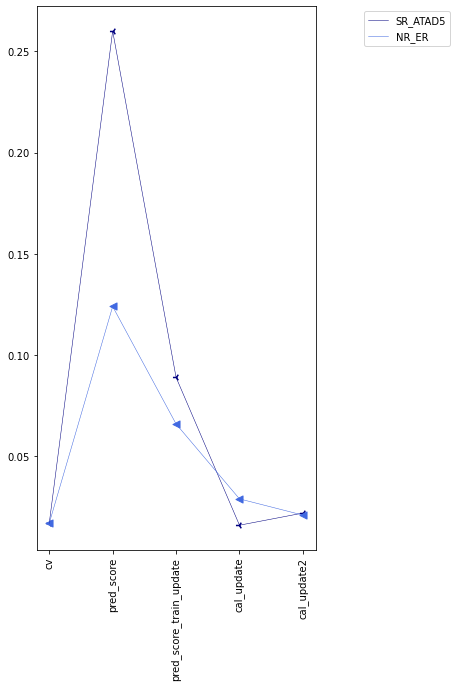

In [21]:
line_plot_rmsd(rmsds, strategies)

<Figure size 432x288 with 0 Axes>

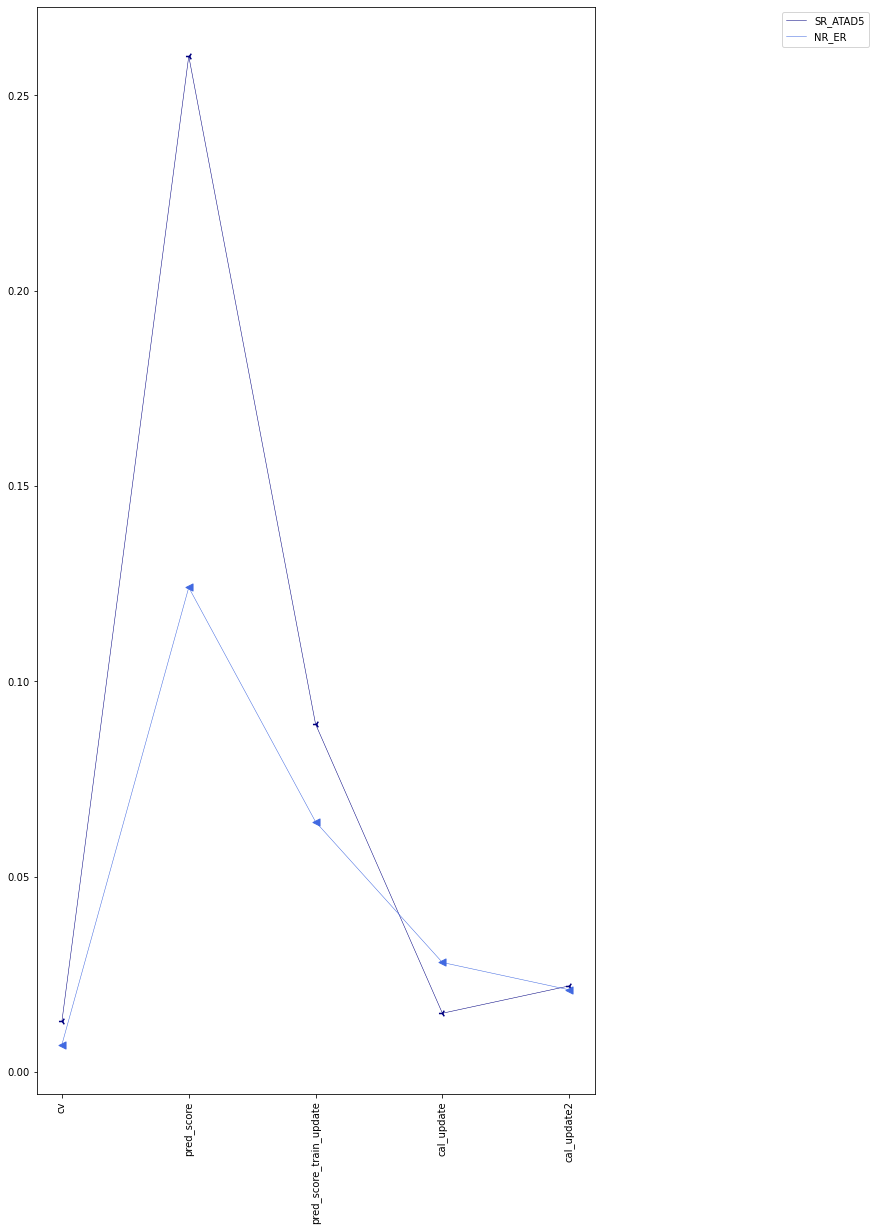

In [22]:
line_plot_rmsd(rmsds_pos, strategies, figsize=(10, 20))